In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
# from funcy import compose
compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices
from para_UBIC import *

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.random import sample_without_replacement
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full
from findiff import FinDiff

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from pysr import PySRRegressor

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2 
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return np.array(Theta_grouped), np.array(Ut_grouped)

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

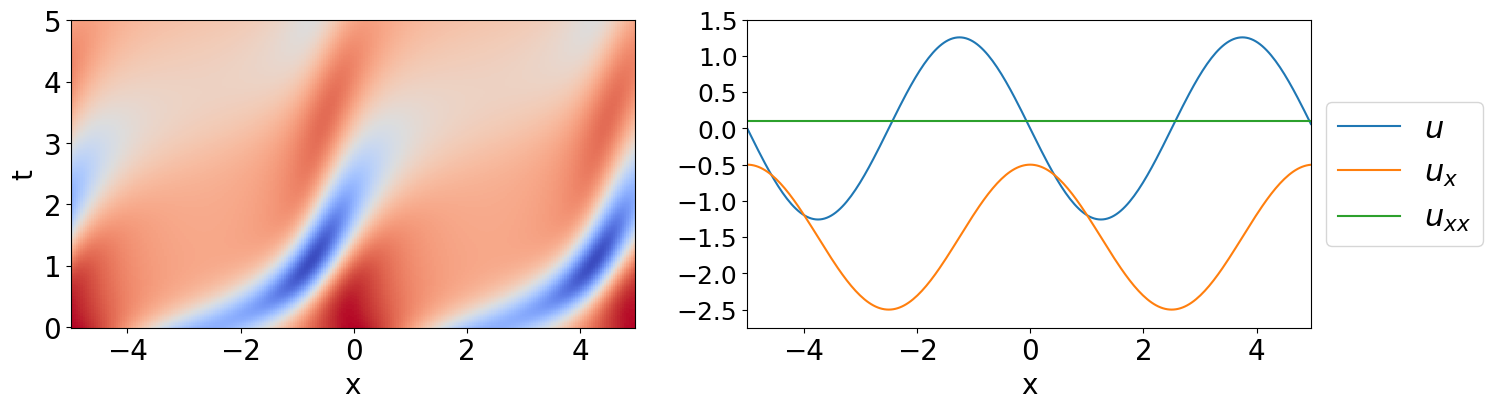

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, 
#                                          time_diff = 'FD', space_diff = 'Fourier')
alpha = 3e-4 # 1e-3 (ok for pysr env. but not ok for pysindy_latest env.)
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                        diff_kwargs, 
                                                                        include_bias=False)
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "spatial")

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
# fft_percent = 90
# acc = 8
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(u)
    
# phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
# phi = phi1.copy(); phi_names = phi1_names.copy()
# phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
# phi = np.array(phi)
# phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
# fft_phi = [remove_f(fft(_), fft_percent) for _ in phi]
# fft_u_t = remove_f(fft(u_t), fft_percent)

# Theta_grouped = np.moveaxis(phi, 0, -1)
# Ut_grouped = np.expand_dims(u_t, -1)
# rhs_des = phi_names
# fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
# fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

# del phi1, phi2, phi1_names, phi2_names

0 u
3 u_x
4 u_xx
5 u_xxx


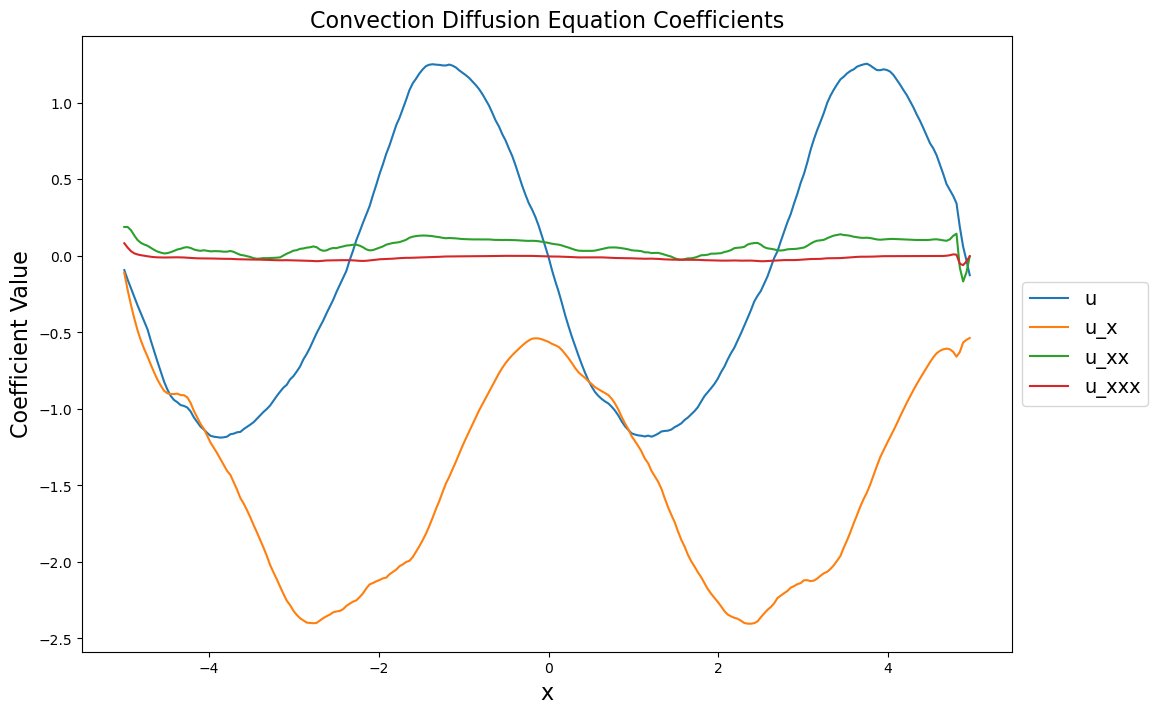

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
true_xi = np.vstack((u_true, u_x_true, u_xx_true))
errors = xi[[0, 3, 4]]-true_xi
errors = 100*np.linalg.norm(errors, axis=1)/np.linalg.norm(true_xi, axis=1)
errors.mean(), errors.std()

(26.5947279206636, 24.589386673980744)

In [10]:
if noise_lv == 2:
    candidates = {(0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
                  (0, 1, 3, 4, 5, 6, 7),
                  (0, 1, 3, 4, 5, 6, 7, 14),
                  (0, 2, 3, 4, 5, 6, 7, 14, 18),
                  (0, 3),
                  (0, 3, 4),
                  (0, 3, 4, 6, 7, 9),
                  (0, 3, 4, 7),
                  (0, 3, 4, 7, 13),
                  (3,)}
    candidates = {(0, 1, 2, 3, 4, 5, 6, 7, 12, 18),
                  (0, 1, 2, 3, 4, 5, 7, 9, 16),
                  (0, 1, 3, 4, 5, 6, 7, 14),
                  (0, 2, 3, 4, 5, 7, 9),
                  (0, 3),
                  (0, 3, 4),
                  (0, 3, 4, 6),
                  (0, 3, 4, 6, 7),
                  (0, 3, 4, 6, 7, 13),
                  (3,)}
elif noise_lv == 4:
    candidates = {(0, 1, 2, 3, 4, 5, 6, 7, 12, 18),
                  (0, 1, 2, 3, 4, 5, 7, 9, 16),
                  (0, 1, 3, 4, 5, 6, 7, 14),
                  (0, 2, 3, 4, 5, 7, 9),
                  (0, 3),
                  (0, 3, 4),
                  (0, 3, 4, 6),
                  (0, 3, 4, 6, 7),
                  (0, 3, 4, 6, 7, 13),
                  (3,)}
    
candidates = sorted(candidates, key=len)
rhs_des[0], rhs_des[3], rhs_des[4]

('u', 'u_x', 'u_xx')

In [11]:
lnorm = 1
n_models = 20
uncerts = [[] for _ in range(len(candidates))]
mean_coeffs = [[] for _ in range(len(candidates))]
std_coeffs = [[] for _ in range(len(candidates))]
for j in trange(len(candidates)):
    for i in range(len(Theta_grouped)):
        np.random.seed(i)
        coeffs = []
        for _ in range(n_models):
            sample_indices = np.random.choice(range(Theta_grouped[i].shape[0]), 
                                              size=int(Theta_grouped[i].shape[0]*0.8), 
                                              replace=True)
            coeffs.append(np.linalg.lstsq(Theta_grouped[i][sample_indices, :][:, candidates[j]], 
                                          Ut_grouped[i][sample_indices, :], rcond=None)[0])
        coeffs = np.hstack(coeffs)
        mean_coeff = coeffs.mean(axis=1)
        std_coeff = coeffs.std(axis=1)
        total_std = np.sum(std_coeff)
        
        if lnorm > 0: uncert = total_std/np.linalg.norm(mean_coeff, lnorm)
        else: uncert = total_std
            
        uncerts[j].append(uncert)
        mean_coeffs[j].append(mean_coeff)
        std_coeffs[j].append(std_coeff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.96it/s]


2


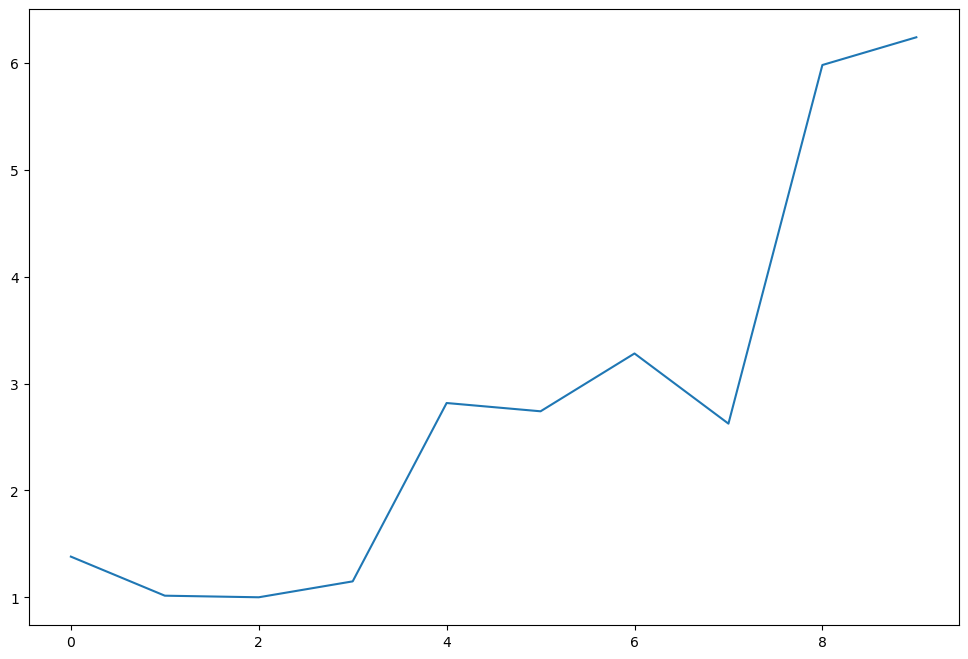

In [12]:
w = 4 # considering from x_{5}
cvs = np.array(uncerts)[:, w:].sum(axis=1)
cvs = cvs/min(cvs); print(np.argmin(cvs))
plt.plot(cvs)

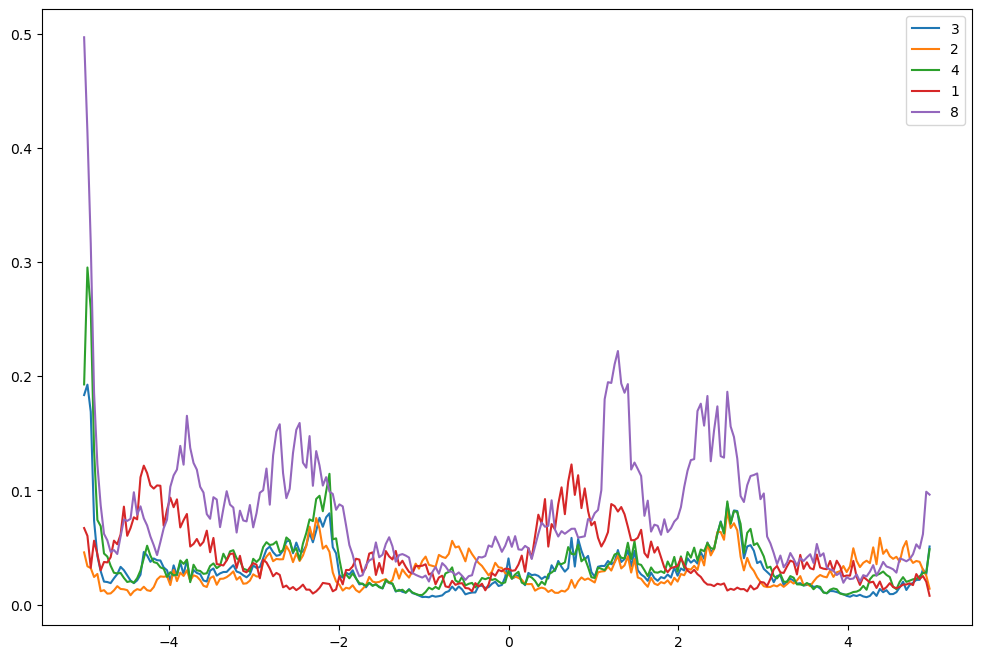

In [13]:
for i in np.argsort(cvs)[:5]:
    plt.plot(x, uncerts[i], label=f'{str(i+1)}')
plt.legend()

<ErrorbarContainer object of 3 artists>

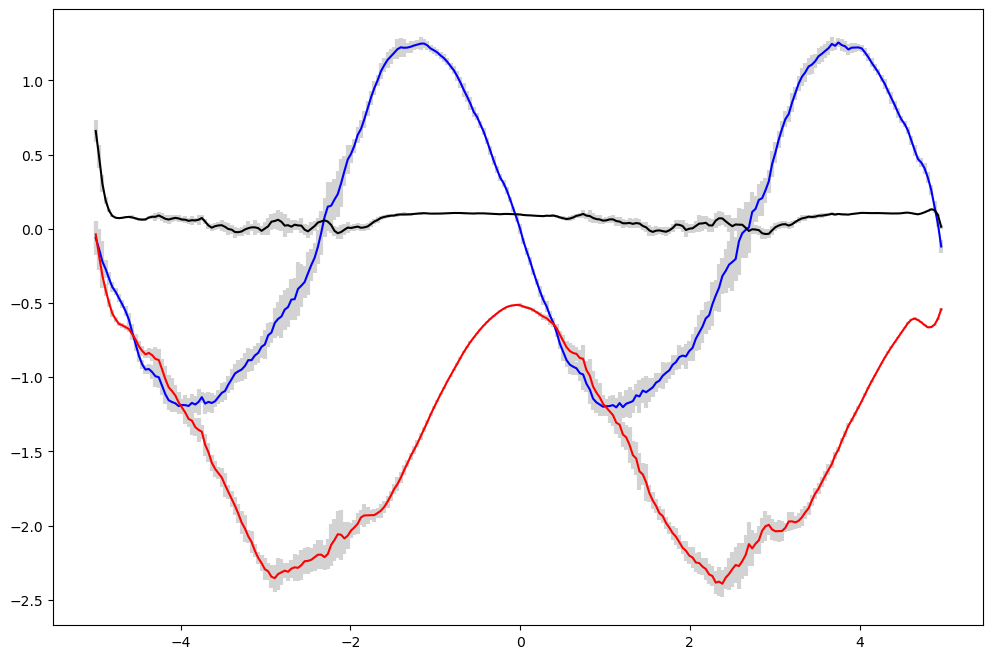

In [14]:
plt.errorbar(x, np.array(mean_coeffs[2])[:,0], yerr=2*np.array(std_coeffs[2])[:,0], 
             fmt='-', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.errorbar(x, np.array(mean_coeffs[2])[:,1], yerr=2*np.array(std_coeffs[2])[:,1], 
             fmt='-', color='red', ecolor='lightgray', elinewidth=3, capsize=0)
plt.errorbar(x, np.array(mean_coeffs[2])[:,2], yerr=2*np.array(std_coeffs[2])[:,2], 
             fmt='-', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

In [15]:
ard_uncerts = [[] for _ in range(len(candidates))]
ard_mean_coeffs = [[] for _ in range(len(candidates))]
ard_std_coeffs = [[] for _ in range(len(candidates))]
for i, indices in enumerate(candidates):
    for j in range(0, len(Theta_grouped), 1):        
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(threshold_lambda=2*1e4, fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        
        coeff = model.coef_
        std_coeff = np.sqrt(np.diag(model.sigma_))
        ard_uncerts[i].append(std_coeff.sum()/np.linalg.norm(coeff, lnorm))
        ard_mean_coeffs[i].append(coeff)
        ard_std_coeffs[i].append(std_coeff)

1


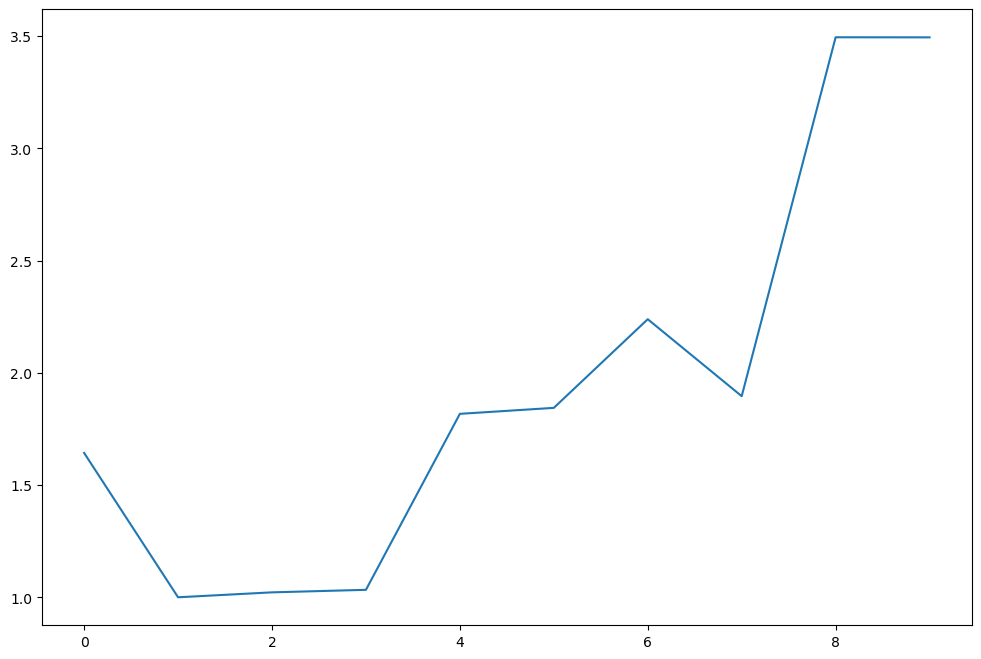

In [16]:
w = 0 # considering from x_{5}
ard_cvs = np.array(ard_uncerts)[:, w:].sum(axis=1)
ard_cvs = ard_cvs/min(ard_cvs); print(np.argmin(ard_cvs))
plt.plot(ard_cvs)

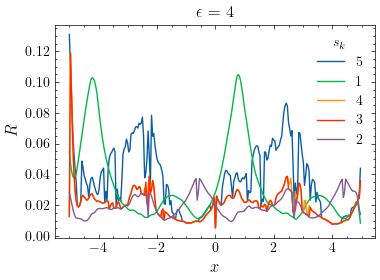

In [17]:
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    for i in np.argsort(ard_cvs)[:5][::-1]:
        ax.plot(x, ard_uncerts[i], label=f'{str(i+1)}')
    ax.set_ylabel("$R$", fontsize=fs)
    ax.set_xlabel("$x$", fontsize=fs)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)
    ax.legend(title="$s_{k}$")
    fig.tight_layout()
    # plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ad_r_noise{noise_lv}.pdf")
    plt.show()

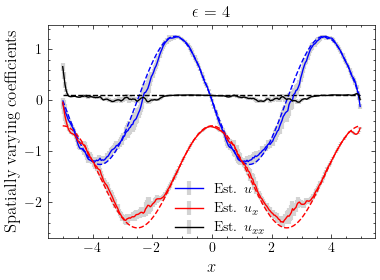

In [18]:
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.errorbar(x, np.array(mean_coeffs[2])[:,0], yerr=2*np.array(std_coeffs[2])[:,0], 
                 fmt='-', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label="Est. $u$")
    ax.errorbar(x, np.array(mean_coeffs[2])[:,1], yerr=2*np.array(std_coeffs[2])[:,1], 
                 fmt='-', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label="Est. $u_{x}$")
    ax.errorbar(x, np.array(mean_coeffs[2])[:,2], yerr=2*np.array(std_coeffs[2])[:,2], 
                 fmt='-', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="Est. $u_{xx}$")
    ax.plot(x, u_true, '--', color='blue')
    ax.plot(x, u_x_true, '--', color='red')
    ax.plot(x, u_xx_true, '--', color='black')
    ax.set_xlabel("$x$", fontsize=fs)
    ax.set_ylabel('Spatially varying coefficients', fontsize=fs)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)
    ax.legend(ncol=1, bbox_to_anchor=(0.525, 0.3125))
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ad_ci_noise{noise_lv}.pdf")
    plt.show()

#### pysr

In [19]:
f_u, f_u_x, f_u_xx = linear_fit_grouped_data((Theta_grouped, Ut_grouped), considered_indices=candidates[2])

In [20]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)

In [21]:
# epsilon=2: y1 = sin(-1.2457551 * x)
# epsilon=4: y1 = sin(x * -1.2415)
model.fit(x.reshape(-1,1), f_u.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.370e+05
Head worker occupation: 29.1%
Progress: 723 / 1500 total iterations (48.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.722e+00  1.594e+01  y = -1.0052
2           7.526e-01  8.274e-01  y = sin(6.2624)
3           6.382e-01  1.649e-01  y = 0.11739 * x₀
4           3.063e-02  3.037e+00  y = sin(-1.2458 * x₀)
6           6.593e-03  7.679e-01  y = 1.2207 * sin(-1.2543 * x₀)
8           4.902e-03  1.482e-01  y = 1.222 * sin(1.2541 * (0.038009 - x₀))
10          4.476e-03  4.541e-02  y = (sin((0.037939 - x₀) * 1.2543) * 1.2221) - 0.020637
11          4.476e-03  4.172e-07  y = (sin(sin(0.047604) - (1.2543 * x₀)) * 1.2221) - 0.02064
13          3.710e-03  9.382e-02  y = sin((((cos(x₀) * -0.05278) - x₀) * 1.2565) - -0.039025) * ...
                                  1.222
14          3.659e-03  1.384e-02  y = sin((((sin(cos(

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          -0.206735   
	1         4.491036e-02                                     sin(6.2624006)   
	2         1.648759e-01                                    0.11738631 * x0   
	3         3.036845e+00                               sin(-1.2457551 * x0)   
	4         7.679193e-01                   1.2207344 * sin(-1.2542922 * x0)   
	5         1.482096e-01    1.2219999 * sin(1.2540681 * (0.038009293 - x0))   
	6         4.541049e-02  (sin((0.037938733 - x0) * 1.2542964) * 1.22212...   
	7         5.138198e-07  (sin(sin(0.04760361) - (1.2542961 * x0)) * 1.2...   
	8         1.004646e-01  1.223319 * sin((((-0.046029728 * cos(x0)) - x0...   
	9         4.990279e-03  sin((((sin(cos(x0)) * -0.052779898) - x0) * 1....   
	10        2.071850e-01  sin(((cos(x0 * -1.2592157) * -0.052779898) - (...   
	11        7.398617e-05  sin(((cos(x0 * -1.2592157) * sin(-0.052779898)...   
	12  >>>>  2.554748e-01  sin((((cos((-0.5330145 + x0) * 1.2643893) * -0...   
	13        7.211660e-04  sin((((cos(((x0 + -0.5330145) - 0.01215959) * ...   
	
	        loss  complexity  
	0   0.787216           1  
	1   0.752644           2  
	2   0.638241           3  
	3   0.030627           4  
	4   0.006593           6  
	5   0.004902           8  
	6   0.004476          10  
	7   0.004476          11  
	8   0.003661          13  
	9   0.003643          14  
	10  0.002961          15  
	11  0.002961          16  
	12  0.002294          17  
	13  0.002290          19  
]

In [22]:
# epsilon=2: y2 = cos(x * 1.2498997) + -1.4502426
# epsilon=4: y2 = cos(-1.2439959 * x) - 1.4215299
model.fit(x.reshape(-1,1), f_u_x.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 3.010e+05
Head worker occupation: 32.7%
Progress: 659 / 1500 total iterations (43.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.965e-01  1.594e+01  y = -1.6701
3           4.505e-01  4.861e-02  y = -0.021697 + -1.4339
4           2.613e-01  5.448e-01  y = cos(x₀) - 1.2639
5           2.422e-01  7.575e-02  y = sin(cos(x₀)) + -1.2852
6           7.579e-03  3.464e+00  y = cos(x₀ * 1.2499) + -1.4502
8           6.080e-03  1.102e-01  y = (cos(x₀ * 1.2534) * 0.93885) + -1.4502
9           6.079e-03  1.019e-04  y = (cos(-1.2518 * x₀) - 1.5409) * cos(0.34627)
10          6.058e-03  3.490e-03  y = ((0.74722 - cos(1.2534 * x₀)) * -0.94404) - 0.74722
11          6.058e-03  4.709e-05  y = (-0.94404 * (0.48015 - cos(x₀ * 1.2534))) - cos(-0.015051)
12          6.058e-03  1.788e-07  y = ((cos(sin(-1.8119)) - cos(1.2534 * x₀)) * -0.94404) 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          -1.455633   
	1         0.181605                                cos(x0) - 1.2638687   
	2         0.075748                          sin(cos(x0)) + -1.2851634   
	3   >>>>  3.464357                   cos(x0 * 1.2498997) + -1.4502426   
	4         0.112051      -1.453171 + (cos(-1.253372 * x0) * 0.9440415)   
	5         0.000003  (-1.5387759 + cos(1.2533386 * (x0 - -0.0006560...   
	6         0.024514  (-1.4502426 + cos(x0 * 1.2322042)) + (-0.08126...   
	7         0.000037  (-1.4502426 + cos(x0 * 1.2322042)) + (sin(-0.0...   
	8         0.010398  (-1.4502426 + cos(x0 * 1.2322042)) + (cos(x0 *...   
	9         0.007289  ((cos(x0 * 0.07398998) - cos(1.2468843 * x0)) ...   
	10        0.003295  (cos(x0 * 1.2322042) + -1.4502426) - ((cos(x0 ...   
	11        0.031737  ((cos((x0 * 0.07398998) - 0.06913316) - cos(1....   
	12        0.042266  (((cos(x0 + x0) * (-0.009019827 * x0)) - cos(1...   
	13        0.008419  ((((cos(x0 + x0) - 0.33818826) * (-0.009019827...   
	14        0.001077  (((cos((cos(-1.1449193) + x0) + x0) * (-0.0090...   
	
	        loss  complexity  
	0   0.450499           1  
	1   0.261266           4  
	2   0.242207           5  
	3   0.007579           6  
	4   0.006058           8  
	5   0.006058          10  
	6   0.005911          11  
	7   0.005911          12  
	8   0.005850          13  
	9   0.005807          14  
	10  0.005788          15  
	11  0.005607          16  
	12  0.005375          17  
	13  0.005285          19  
	14  0.005280          20  
]

In [23]:
# epsilon=2: y3 = sin(0.087467626)
# epsilon=4: y3 = 0.064058535
model.fit(x.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 3.730e+05
Head worker occupation: 21.1%
Progress: 821 / 1500 total iterations (54.733%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           4.985e-03  7.971e+00  y = sin(0.087468)
3           4.985e-03  -0.000e+00  y = sin(sin(0.08759))
5           4.918e-03  6.816e-03  y = (-0.0028465 * x₀) - -0.087309
6           4.860e-03  1.178e-02  y = 0.12273 * cos(cos(sin(x₀)))
7           4.356e-03  1.095e-01  y = 0.12273 * cos(sin(x₀ * 0.58623))
8           4.317e-03  9.084e-03  y = sin(cos(sin(0.62046 * x₀)) * 0.11818)
9           4.311e-03  1.423e-03  y = 0.12273 * cos(sin(x₀ * 0.58623) * 1.0566)
10          4.279e-03  7.428e-03  y = sin(0.11576 * cos(sin((0.19118 + x₀) * 0.6203)))
11          3.852e-03  1.052e-01  y = sin((sin(x₀ * -0.75594) * (x₀ * 0.024629)) - -0.10837)
12          3.848e-03  8.745e-04  y = sin((x₀ * (sin(x₀ * sin(-0.84308)

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                           1.163793   
	1         5.452832e+00                                   sin(0.087467626)   
	2         1.002929e-07                               sin(sin(0.08758992))   
	3         6.816381e-03                   (-0.00284647 * x0) - -0.08730896   
	4         1.178442e-02                       0.122734 * cos(cos(sin(x0)))   
	5         1.094516e-01                0.122734 * cos(sin(x0 * 0.5862273))   
	6         9.083840e-03         sin(cos(sin(0.62046164 * x0)) * 0.1181799)   
	7         1.514712e-02  sin((cos(x0 * -1.2343626) * 0.038811296) - -0....   
	8         4.139136e-06  sin(sin(cos(x0 * -1.2343626) * 0.038811296) - ...   
	9         9.885379e-02  sin((sin(x0 * -0.75593686) * (x0 * 0.02462921)...   
	10        9.077919e-04  sin(((x0 * sin(sin(-0.8430742) * x0)) * 0.0262...   
	11        2.043379e-02  sin((x0 * (0.022079954 * (sin(-1.0470612 - x0)...   
	12        1.181867e-02  sin((x0 * ((sin(sin(-1.1320549 - x0)) - 0.4664...   
	13        5.151952e-02  sin(((0.023631642 * (sin(-1.1479391 - x0) - 0....   
	14        9.022662e-03  sin((((sin(sin(-1.1479391 - x0)) - 0.46612346)...   
	15        2.116367e-04  sin((((sin(sin(-1.1479391 - x0)) - cos(1.08935...   
	16        4.504336e-02  sin(((0.0413172 * (sin((cos(0.83543897 + x0) -...   
	17        3.306850e-02  sin(((0.061124995 * sin(sin((cos(x0 + 0.952356...   
	18  >>>>  1.447945e-01  sin(((0.79655075 - x0) * (-0.050826244 * (sin(...   
	
	        loss  complexity  
	0   1.163683           1  
	1   0.004985           2  
	2   0.004985           3  
	3   0.004918           5  
	4   0.004860           6  
	5   0.004356           7  
	6   0.004317           8  
	7   0.004252           9  
	8   0.004252          10  
	9   0.003852          11  
	10  0.003848          12  
	11  0.003771          13  
	12  0.003726          14  
	13  0.003539          15  
	14  0.003507          16  
	15  0.003507          17  
	16  0.003352          18  
	17  0.003243          19  
	18  0.002806          20  
]

In [24]:
y1 = sin(-1.2457551 * x)
y2 = cos(x * 1.2498997) + -1.4502426
y3 = sin(0.087467626)*np.ones(len(x))

coeff_error(y1, u_true), coeff_error(y2, u_x_true), coeff_error(y3, u_xx_true)

(20.047466581802556, 2.9579445595502887, 12.643861104334084)

#### epsilon=4

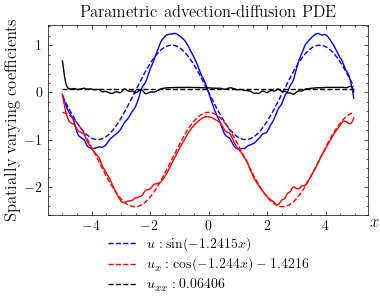

In [20]:
y1 = sin(x * -1.2415)
y2 = cos(-1.2439959 * x) - 1.4215299
y3 = 0.064058535*np.ones(len(x))
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(x, f_u, '-', c='blue')
    ax.plot(x, y1, '--', c='blue', label='$u: \sin(-1.2415x)$')
    ax.plot(x, f_u_x, '-', c='red')
    ax.plot(x, y2, '--', c='red', label='$u_{x}: \cos(-1.244x)-1.4216$')
    ax.plot(x, f_u_xx, '-', c='black')
    ax.plot(x, y3, '--', c='black', label='$u_{xx}: 0.06406$')
    ax.set_ylabel('Spatially varying coefficients', fontsize=fs)
    ax.set_xlabel('$x$', fontsize=fs)
    ax.xaxis.set_label_coords(1.02, 0)
    ax.set_title("Parametric advection-diffusion PDE", fontsize=fs)
    ax.legend(fontsize=fs)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=False, shadow=False, ncol=1)
    fig.tight_layout()
    # plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ad_vc_noise{noise_lv}.pdf")
    plt.show()

In [21]:
y1 = sin(x * -1.2415) # sin(-1.241513 * x0)
y2 = cos(-1.2439959 * x) - 1.4215299
y3 = 0.064058535*np.ones(len(x))
coeff_error(y1, u_true), coeff_error(y2, u_x_true), coeff_error(y3, u_xx_true)

(20.060213564549223, 4.55447494390143, 35.941465)

In [22]:
# propose
# significant testing (จำนวนกลุ่มตัวอย่างที่สุ่มออกมาเท่ากับ len(x) or len(t)) 
# + BIC in peridogram (& weak-form space for ordinary PDEs)
# note: epsilon = 1e-5
# metric learning not sure ... (optional)
# target PDEs Parametric Burgers, AD, KS + (Burgers&KS for ordinary PDEs)